In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
import tqdm

In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
Data = pd.read_excel(r'database.xlsx', index_col=0)

### Dataset construction

In [5]:
rows_to_drop = []
for i in tqdm.tqdm(range(len(Data))):
    if 'Cu' in Data.index[i] or 'Fe' in Data.index[i] or 'Ni' in Data.index[i] or 'O' in Data.index[i] or Data['Tc'].iloc[i]>50:
        rows_to_drop.append(Data.index[i])
        
data_reduced = Data.drop(rows_to_drop)
train_df, test_df = train_test_split(data_reduced, test_size=0.15, random_state=0)

100%|████████████████████████████████████████████████████████████████████████| 16763/16763 [00:00<00:00, 116407.37it/s]


## Pipeline Hypertuning

In [10]:
etr = ExtraTreesRegressor(random_state = 0)

pipe = Pipeline([
    ('decorrelation', MyDecorrelator(0.9)), 
    ('threshold', VarianceThreshold(threshold = 0)), 
    ('feature_selector', SelectPercentile(f_regression)), 
    ('etr', etr)
], verbose = 1)

param_grid = {
    "etr__n_estimators": [100, 250, 500, 750, 1000],                    #Tune the number of estimators
    "etr__max_features": [1, 0.9, 0.8, 0.7, 0.6, 0.5],                 #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [50, 75, 100]             #Tune the percentage of features to retain in terms of f_regression score
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose = 1, cv = 5)

In [12]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Pipeline] ..... (step 1 of 4) Processing decorrelation, total=   0.6s
[Pipeline] ......... (step 2 of 4) Processing threshold, total=   0.1s
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing etr, total=  59.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_selector',
                                        SelectPercentile(score_func=<function f_regression at 0x000001BE7CC5D558>)),
                                       ('etr',
                                        ExtraTreesRegressor(random_state=0))],
                                verbose=1),
             n_jobs=-1,
             param_grid={'etr__max_features': [1, 0.9, 0.8, 0.7, 0.6, 0.5],
                         'etr__n_estimators': [100, 250, 500, 750, 1000],
                         'feature_selector__percentile': [50, 75, 100]},
             verbose=1)

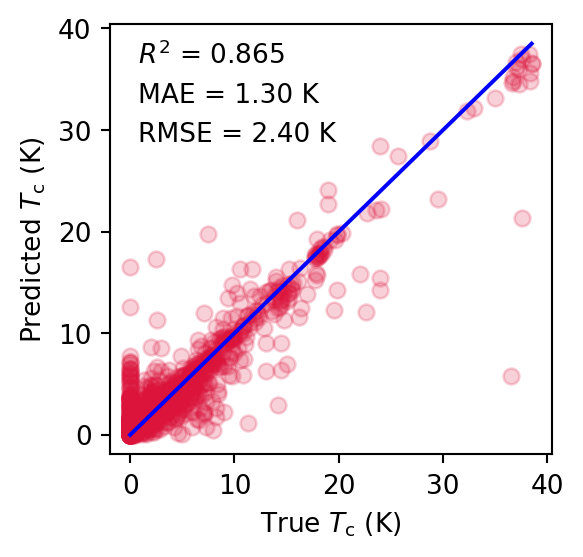

In [14]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values


test_predictions = search.predict(
    test_df.iloc[:, :-1]
)  # Predicted y over samples of the testing set
test_labels = test_df.iloc[:, -1].values  # True y over samples of the testing set

r2 = sklearn.metrics.r2_score(
    test_labels, test_predictions
)  # coefficient of determination
mae = mean_absolute_error(test_labels, test_predictions)  # mean absolute error
rmse = np.sqrt(
    mean_squared_error(test_labels, test_predictions)
)  # root mean squared error

delta = max(test_labels) - min(test_labels)

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3), dpi=190)
plt.scatter(test_labels, test_predictions, c="crimson", alpha=0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], "b-")
plt.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
plt.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
plt.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)
plt.xlabel("True $T_\mathrm{c}$ (K)")
plt.ylabel("Predicted $T_\mathrm{c}$ (K)")
plt.show()

## Manual refitting

This is necessary to run the treeSHAP

In [15]:
X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)
            
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

X_train = X_train.loc[:, SelectPercentile(f_regression, percentile = 75).fit(X_train, y_train).get_support()]
X_test = X_test[X_train.columns]

In [20]:
etr = ExtraTreesRegressor(random_state=0, n_estimators = 1000, max_features = 0.9)
etr.fit(X_train, y_train)

y_predictions = etr.predict(X_test)

In [72]:
from joblib import dump, load
dump(search, 'ETR_metallic.joblib') 

['ETR_metallic.joblib']

## SHAP Analysis

In [22]:
import shap
explainer = shap.TreeExplainer(etr)
shap_values = explainer.shap_values(X_test)

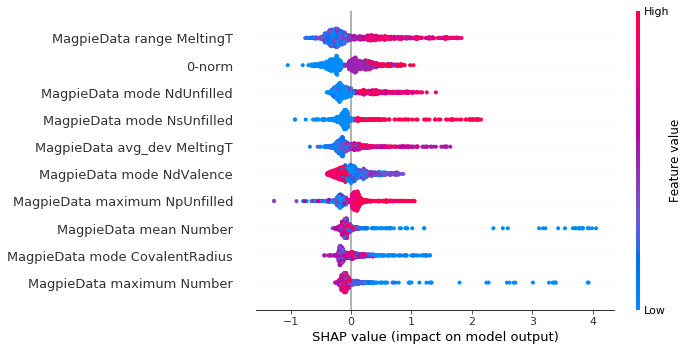

In [23]:
shap.summary_plot(shap_values, X_test, max_display = 10)

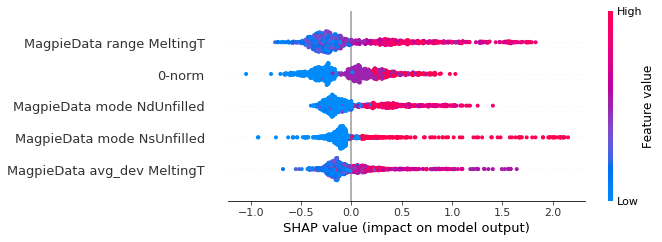

In [24]:
shap.summary_plot(shap_values, X_test, max_display = 5)

In [69]:
Output_shap = pd.DataFrame(shap_values, index = X_test.index, columns = X_test.columns)
Output_shap_mean = pd.DataFrame(abs(Output_shap).describe().loc['mean']/sum(abs(Output_shap).describe().loc['mean'])).sort_values('mean', ascending = False)
Output_shap_mean.to_excel('SHAP_for_ETR_metallic_mean.xlsx')

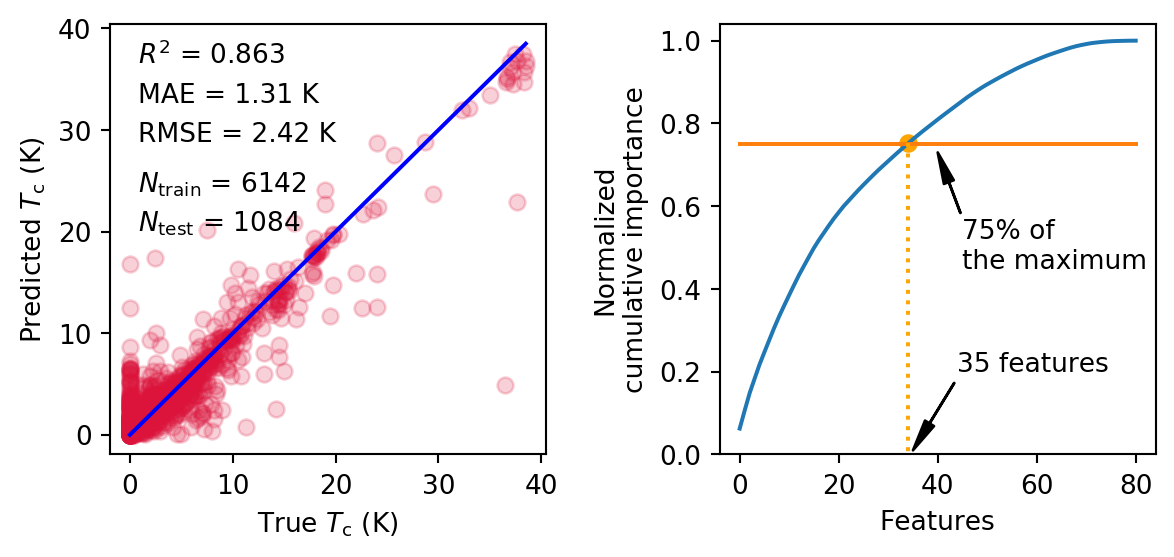

In [80]:
N = np.shape(X_test)[1]
k = 0.75
cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])/(np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.1, 3), dpi = 190)                                                                                       
#fig, ax = plt.subplots(figsize=(3, 3), dpi = 190)


ax1.scatter(test_labels, y_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
ax1.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
ax1.annotate(
    "$R^2$ = %0.3f" % r2,
    xy=(0.02 * delta, 0.95 * delta),
    xytext=(0.02 * delta, 0.95 * delta),
)
ax1.annotate(
    "MAE = %0.2f K" % mae,
    xy=(0.02 * delta, 0.85 * delta),
    xytext=(0.02 * delta, 0.85 * delta),
)
ax1.annotate(
    "RMSE = %0.2f K" % rmse,
    xy=(0.02 * delta, 0.75 * delta),
    xytext=(0.02 * delta, 0.75 * delta),
)

ax1.annotate(r'$N_{\rm{train}}$ = %0.0f' % len(train_df), xy=(0.02 * delta, 0.62 * delta), xytext=(0.02 * delta, 0.62 * delta),
            )
ax1.annotate(r'$N_{\rm{test}}$ = %0.0f' % len(test_df), xy=(0.02 * delta, 0.52 * delta), xytext=(0.02 * delta, 0.52 * delta),
            )

ax1.set_xlabel("True $T_\mathrm{c}$ (K)")
ax1.set_ylabel("Predicted $T_\mathrm{c}$ (K)")






ax2.plot(np.arange(N), normalized_cumulative)
ax2.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k*max(normalized_cumulative)*np.ones(N)))
#plt.yticks(np.array([0, 0.5, 1]))

ax2.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax2.annotate('75% of\nthe maximum', xy=(40, 0.73), xytext=(45, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
ax2.scatter(ind_cross1, normalized_cumulative[ind_cross1], color = 'orange')
ax2.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color = 'orange', ls = ':')
ax2.set_ylim(0, 1.04)
ax2.set_xlabel('Features')
ax2.set_ylabel('Normalized\ncumulative importance')

plt.subplots_adjust(wspace=0.4)

plt.show()